In [21]:
# tensorflow==2.3.0
! mkdir -p ~/aiffel/object_detection/data
! cd ~/aiffel/object_detection

In [3]:
! cd ~/cv6/object_detection

In [22]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [23]:
! git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [1]:
! cd keras-retinanet && python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [ ]:
! pip install tensorflow_datasets tqdm
! pip install -r requirements.txt
! pip install .

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2852631715381539314
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14378909008065121851
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5106066473661361237
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7113333824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5015997411535072306
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# 6.2 자율주행 보조장치 (1) KITTI 데이터셋
- 자율주행 보조장치(object detection) 요구사항  

    1) 사람이 카메라에 감지되면 정지한다.  
    2) 차량이 일정 크기 이상으로 감지되면 정지한다.    
    
  
- tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용하자
- 자율 주행을 위한 데이터셋으로 2D object detection 뿐만 아니라, 깊이 까지 포함한 3D object detection 라벨 등을 제공하고 있다.

In [18]:
# 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [7]:
# KITTI 데이터셋 다운로드
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

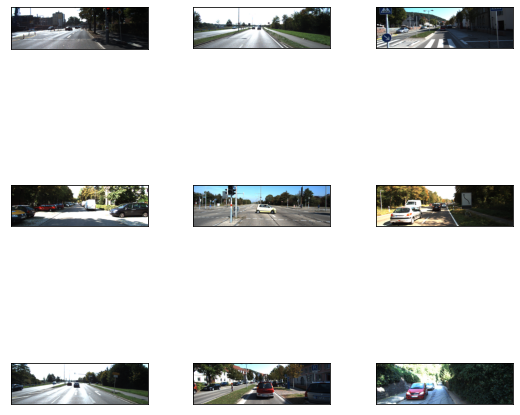

In [8]:
# 다운로드 한 KITTI 데이터셋을 tfds.show_examples를 통해 살펴보자
# 일반적인 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인한다.
fig = tfds.show_examples(ds_train, ds_info)

- 데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있다.
- 학습 데이터 (training data) : 7,481개
- 평가용 데이터 (test data) : 711개
- 검증용 데이터 (validation data) : 423개
- 라벨 : alpah, bbox, dimensions,location, occluded, rotation_y, truncated 등의 정보가 있다.

In [9]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

# 6-3. 자율주행 보조장치 (2) 데이터 직접 확인하기
- ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 TakeDataset을 얻는다.
- 이렇게 뽑은 데이터에는 image 정보가 포함되어 있다.

In [10]:
# 데이터 하나씩 뽑아본다 - image 정보 포함
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.83,  1.66,  1.44,  1.59, -1.63], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.14450666, 0.589372  , 0.50901335, 0.7487923 ],
       [0.41010666, 0.41397744, 0.53024   , 0.45727053],
       [0.38656   , 0.53527373, 0.52813333, 0.5898631 ],
       [0.46429333, 0.44683576, 0.53474665, 0.47010466],
       [0.46432   , 0.52062804, 0.54293334, 0.5474316 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.46, 1.54, 3.62],
       [1.52, 1.57, 4.42],
       [1.51, 1.58, 3.92],
       [1.46, 1.6 , 3.33],
       [1.64, 1.7 , 3.54]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 2.68,  1.63,  9.69],
       [-2.51,  1.66, 26.76],
       [ 2.66,  1.66, 22.69],
       [-2.36,  1.58, 41.98],
       [ 3.06,  1.59, 42.35]], dtype=float32)>, 'oc

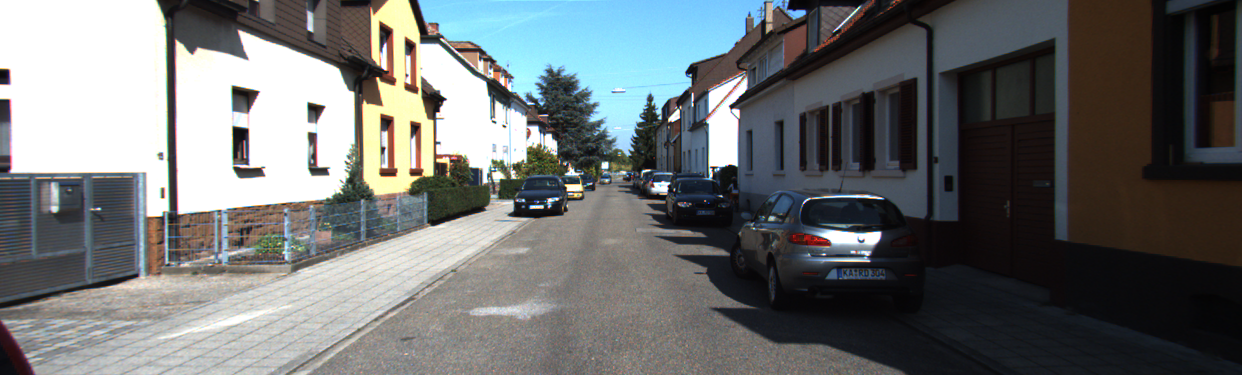

In [11]:
# 이미지와 라벨 얻는 방법
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

#### 이미지의 바운딩 박스(bounding box,bbox) 확인 하기
#### KITTI에서 제공하는 데이터셋
![image](https://user-images.githubusercontent.com/77032087/116091085-7a9d9e80-a6df-11eb-9d58-1af4eb37a0bc.png)
  
![image](https://user-images.githubusercontent.com/77032087/116091244-9a34c700-a6df-11eb-9054-710e5a5cd82b.png)  
  
   Pillow 라이브러리의 ImageDraw 모듈을 참고https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html

width: 1242  height: 375
(5, 4)
[732.   320.81 930.   184.12]
[514.16 221.21 567.93 176.16]
[664.81    230.04001 732.61    176.95   ]
[554.97003 200.89    583.87    174.47   ]
[646.62    200.88    679.91003 171.4    ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F508859D450>


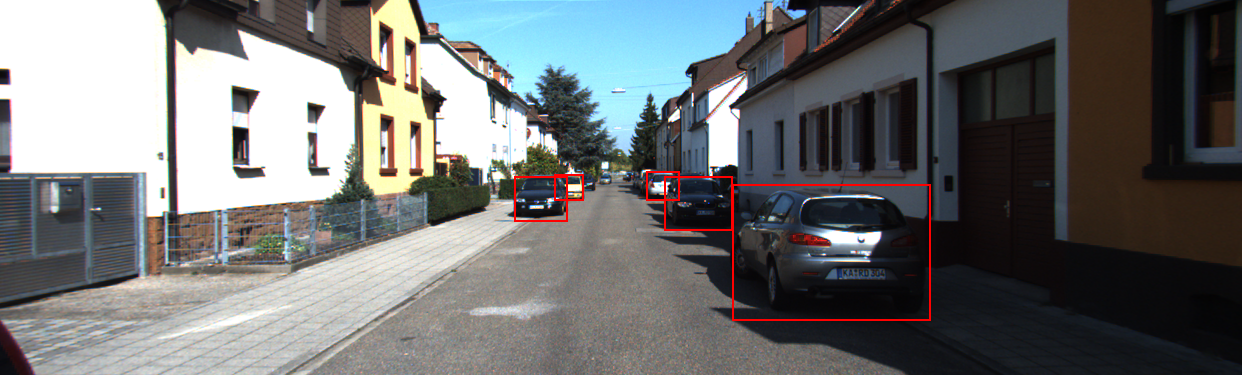

In [12]:
# 이미지 위에 바운딩 박스 그려서 화면에 표시하기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())


# 6-4. RetinaNet
- Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델이다.
- Detecton 모델을 직접 만들기는 많은 시간이 소요되므로, 미리 모델을 구현한 라이브러리를 가져와 커스텀 데이터셋에 학습시키고 빠르게 사용해보려 한다.  
    
    ---  
  
- 1-stage detector 모델인 **YOLO와 SSD**는 2-stage detector인 **Faster-RCNN** 등 보다 속도는 빠르지만, 성능이 낮은 문제점을 가지고 있다.  
- 이를 해결하기 위해 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용한다.   
![image](https://user-images.githubusercontent.com/77032087/116094315-660ed580-a6e2-11eb-81e7-f5a87d2875b0.png)


### Focal Loss
- 기존의 1-stage detection 모델들(YOLO,SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한번에 학습됨으로 인해 생기는 클래스 간의 불균형을 해결하고자 도입 되었다.  
  
**픽셀/그리드**  

- 픽셀(pixel) : 왼쪽 7x7 feature level에서는 한 픽셀
- 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field이다.  
  
우리가 사용하는 이미지는 물체보다 많은 배경을 학습한다. 이를 해결하기 위해 Loss를 개선하여 정확도를 높였다.  
![image](https://user-images.githubusercontent.com/77032087/116095816-b6d2fe00-a6e3-11eb-86fd-5761ef35f86b.png)
  
- Focal loss는 우리가 많이 사용하던 교차 엔트로피를 기반으로 만들어졌다.
- 위 그림에서 Focal loss는 그저 교차 엔트로피 CE(pt)의 앞단에 간단히 (1-pt)r 라는 modulating factor를 붙였다.  
  
    
- 교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실이 나타난다.  
- 이 상황은 물체 검출 모델을 학습 시키는 과정에서 문제가 된다. 대부분의 이미지에서는 물체보다 배경이 많다. 
- 따라서, 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있다.
- 이렇게 너무 많은 배경 class에 압도 되지 않도록 modulating factor로 손실을 조절해 준다.
- 람다는 0으로 설정하면 modulating factor가 0이 되어 일반적인 교차 엔트로피가 되고, 람다가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있다.  

![image](https://user-images.githubusercontent.com/77032087/116102956-221fce80-a6ea-11eb-890c-51f7c94b3699.png)


### FPN(Feature Pyramid Network)
- FPN은 특성을 피라미드 처럼 쌓아서 사용하는 방식이다. 
#### receptive field
- CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용한다. 
- 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽 특성맵 일수록 하나의 셀cell이 넓은 이미지 영역의 정보를 담고 있고,
- 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있다.
- 이를 receptive field라고 하며, 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 된다.

- FPN은 백본의 여러 레이러르 한꺼번에 쓰겠다라는데 의의가 있다.
- SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면, RetinaNet에서는 receptive field가 넓은 뒷쪽 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했다.
- 레이어가 깊어질수록 feature map의 w,h 방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적이다.  

![image](https://user-images.githubusercontent.com/77032087/116105530-5e542e80-a6ec-11eb-8d53-f7b002032edf.png)  
- 위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림이다. FPN은 각 level이 256 채널로 이루어지는데, RetinaNet에서는 FPN의 P3부터 P7까지의 Pyramid level을 사용한다. 
- 이를 통해 Classification Subnet과 BoxRegression Subnet 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 A라고 하면 최종적으로 Classification Subnet은 K개 class에 대해 KA개 채널을, Box Regression Subnet은 4A개 채널을 사용하게 된다.

# 6-5. keras-retinanet 실습(1) 데이터 포맷 변경
- Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet이다.
  
- 우리가 가진 tensorflow_dataset의 KITTI 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야 한다. 
- 하지만 이보다 더 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법이다.

### 클래스 및 바운딩 박스 정보 추출
- tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었다.
- 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해보자



In [13]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)



100%|██████████| 6347/6347 [12:11<00:00,  8.68it/s]


In [14]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:31<00:00,  7.81it/s]


In [15]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)


# 6-6

In [14]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-28 00:51:40.379026: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-28 00:51:41.360588: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-28 00:51:41.385423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-28 00:51:41.385845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-28 00:51:41.385868: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-28 00:51:41.388741: I tensorflow/stream_executor/platform/

res4b_branch2b_relu (Activation (None, None, None, 2 0           bn4b_branch2b[0][0]              
__________________________________________________________________________________________________
res4b_branch2c (Conv2D)         (None, None, None, 1 262144      res4b_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn4b_branch2c (BatchNormalizati (None, None, None, 1 4096        res4b_branch2c[0][0]             
__________________________________________________________________________________________________
res4b (Add)                     (None, None, None, 1 0           bn4b_branch2c[0][0]              
                                                                 res4a_relu[0][0]                 
__________________________________________________________________________________________________
res4b_relu (Activation)         (None, None, None, 1 0           res4b[0][0]                      
__________

Epoch 1/50
2021-04-28 00:51:50.788782: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-28 00:51:52.517294: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-28 00:51:52.549979: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-28 00:51:52.842056: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-04-28 00:52:09.562360: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
195/

195/195 [==============================] - ETA: 0s - loss: 1.4936 - regression_loss: 1.1662 - classification_loss: 0.3274
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
195/195 [==============================] - 64s 326ms/step - loss: 1.4936 - regression_loss: 1.1662 - classification_loss: 0.3274
Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.3195 - regression_loss: 1.0287 - classification_loss: 0.2908
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 63s 325ms/step - loss: 1.3195 - regression_loss: 1.0287 - classification_loss: 0.2908
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.3237 - regression_loss: 1.0135 - classification_loss: 0.3102
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 64s 330ms/step - loss: 1.3237 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.1137 - regression_loss: 0.8505 - classification_loss: 0.2632
Epoch 00030: saving model to ./snapshots/resnet50_csv_30.h5
195/195 [==============================] - 62s 320ms/step - loss: 1.1137 - regression_loss: 0.8505 - classification_loss: 0.2632
Epoch 31/50
195/195 [==============================] - ETA: 0s - loss: 1.1130 - regression_loss: 0.8422 - classification_loss: 0.2708
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5
195/195 [==============================] - 65s 333ms/step - loss: 1.1130 - regression_loss: 0.8422 - classification_loss: 0.2708
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 1.1186 - regression_loss: 0.8491 - classification_loss: 0.2695
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 64s 327ms/step - loss: 1.1186 - regression_loss: 0.8491 - classification_loss: 0.2695
Epoch 33/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 1.0721 - regression_loss: 0.8239 - classification_loss: 0.2482
Epoch 00046: saving model to ./snapshots/resnet50_csv_46.h5

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
195/195 [==============================] - 64s 327ms/step - loss: 1.0721 - regression_loss: 0.8239 - classification_loss: 0.2482
Epoch 47/50
195/195 [==============================] - ETA: 0s - loss: 1.1255 - regression_loss: 0.8358 - classification_loss: 0.2897
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5
195/195 [==============================] - 64s 328ms/step - loss: 1.1255 - regression_loss: 0.8358 - classification_loss: 0.2897
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.0961 - regression_loss: 0.8389 - classification_loss: 0.2572
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.
195/195 [=

In [15]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-28 01:50:45.346711: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-28 01:50:46.850646: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-28 01:50:46.886860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-28 01:50:46.888290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-28 01:50:46.888374: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-28 01:50:46.894786: I tensorflow/stream_executor/platform/

# 6-7. keras-retinanet 실습 (3) 시각화
- 변환한 모델을 load하고 추론 및 시각화하기
- 아래 load된 모델을 통해 추론하고, 시각화 하는 함수를 작성한다. 
- 일정 점수 이하의 경우는 모두 제거해주어야 한다.

In [16]:
# 테스트셋 받기
! mkdir -p ~/aiffel/object_detection/test_set
! wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
! mv test_set.zip ~/aiffel/object_detection/test_set
! cd ~/aiffel/object_detection/test_set && unzip test_set.zip

--2021-04-28 01:52:14--  https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7547109 (7.2M) [application/zip]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>]   7.20M  4.31MB/s    in 1.7s    

2021-04-28 01:52:16 (4.31 MB/s) - ‘test_set.zip’ saved [7547109/7547109]

Archive:  test_set.zip
  inflating: go_1.png                
  inflating: go_2.png                
  inflating: go_3.png                
  inflating: go_4.png                
  inflating: go_5.png                
  inflating: stop_1.png              
  inflating: stop_2.png              
  inflating: stop_3.png              
  inflating: stop_4.png              
  inflating: stop_5.png              

In [20]:
! pip install keras_retinanet

     |████████████████████████████████| 71 kB 1.4 MB/s eta 0:00:011
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=167662 sha256=1f8fc219776cac54722d2bbec44e5b429201a8bfd930891ae8c6c396ba26a0e1
  Stored in directory: /home/aiffel/.cache/pip/wheels/55/a1/41/f2dbc08b26549fe00041b9bc25c299f262b0311ad68cc52522
Successfully built keras-retinanet


In [21]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[591.38654 174.62355 624.58936 206.8649 ]
[195.63026 136.21587 354.0817  228.41093]


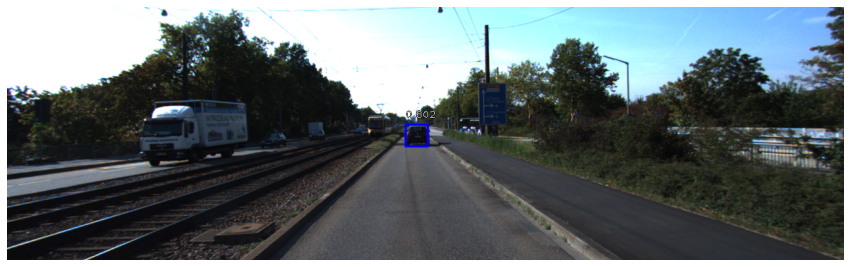

In [22]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)


# 6-8. 프로젝트 : 자율주행 보조 시스템 만들기
## 1) 자율주행 시스템 만들기
- 위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만든다.
    - 입력으로 이미지 경로를 받습니다.
    - 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
        - 조건은 다음과 같습니다.
        - 사람이 한 명 이상 있는 경우
        - 차량의 크기(width or height)가 300px이상인 경우


In [40]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    
    image = read_image_bgr(img_path)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    w=0
    h=0
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.43:
            break

        b = box.astype(int)
        w = b[2]-b[0]
        h = b[3]-b[1]

        # 조건 1 - 사람이 1명 이상 있는 경우
        if label ==1:
            return 'Stop'
        # 조건 2 - 차량 크기가 300px 이상인 경우
        elif label==0:
            if w>=size_limit or h>=size_limit:
                return 'Stop'
        
        else:
            return 'Go'
    
print(self_drive_assist(img_path))

Stop


## 2) 자율주행 시스템 평가하기
- 아래 test_system()을 통해서 위에서 만든 함수를 평가한다.
- 10장에 대해 GO,Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가한다.

In [41]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

50점입니다.
